# Qn 1

Given 5 binary patterns of 3 x 3 matrices = 9 input neurons.

4 hidden neurons and reconstruct to 9 output neurons.

Autoencoder: activation function: sigmoid

Without sparsity contstraint, calculate the mse and update weights with gradient descent

With sparsity constrint, add a penalty to the mse before updating weights with gradient descent

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SparseAutoencoder:
    def __init__(self, input_size, hidden_size, alpha=0.1, beta=0.0, rho=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.alpha = alpha
        self.beta = beta
        self.rho = rho

        # Initialise weights and biases
        self.W1 = np.random.randn(hidden_size, input_size) * 0.1
        self.W2 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((input_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def kl_divergence(self, rho_hat):
        """Compute KL divergence for sparsity"""
        return self.rho * np.log(self.rho / (rho_hat + 1e-8)) + \
               (1 - self.rho) * np.log((1 - self.rho) / (1 - rho_hat + 1e-8))

    def forward(self, x):
        """Forward pass"""
        self.z1 = np.dot(self.W1, x) + self.b1
        self.h = self.sigmoid(self.z1)
        self.z2 = np.dot(self.W2, self.h) + self.b2
        self.y = self.sigmoid(self.z2)
        return self.y

    def backward(self, x):
        """Backward pass with sparsity constraint"""
        # Reconstruction error
        error = self.y - x

        # Output layer gradients
        delta2 = error * self.sigmoid_derivative(self.y)

        # Hidden layer gradients with sparsity
        rho_hat = np.mean(self.h, axis=1, keepdims=True)
        sparsity_penalty = self.beta * (-self.rho/(rho_hat + 1e-8) + (1 - self.rho)/(1 - rho_hat + 1e-8))

        delta1 = (np.dot(self.W2.T, delta2) + sparsity_penalty) * self.sigmoid_derivative(self.h)

        # Update weights and biases
        self.W2 += self.alpha * np.dot(delta2, self.h.T)
        self.b2 += self.alpha * np.sum(delta2, axis=1, keepdims=True)
        self.W1 += self.alpha * np.dot(delta1, x.T)
        self.b1 += self.alpha * np.sum(delta1, axis=1, keepdims=True)

        return np.mean(error ** 2)

    def train(self, patterns, epochs=1000):
        """Train the autoencoder"""
        losses = []

        for epoch in range(epochs):
            total_loss = 0

            for pattern in patterns:
                x = pattern.reshape(-1,1)
                self.forward(x)
                loss = self.backward(x)
                total_loss += loss

            losses.append(total_loss / len(patterns))

            # Check convergence
            if epoch > 100 and abs(losses[-1] - losses[-2]) < 1e-6:
                print(f"Converged at epoch {epoch}")
                break

        return losses

    def get_hidden_activations(self, patterns):
        """Get hidden layer activations for all patterns"""
        activations = []
        for pattern in patterns:
            x = pattern.reshape(-1,1)
            self.forward(x)
            activations.append(self.h.flatten())
        return np.array(activations)

    def reconstruct(self, patterns):
        """Reconstruct patterns"""
        reconstructions = []
        for pattern in patterns:
            x = pattern.reshape(-1,1)
            y = self.forward(x)
            reconstructions.append(y.flatten())
        return np.array(reconstructions)

# Define the patterns
patterns = [
    np.array([[1,1,1],[0,0,0],[0,0,0]]),
    np.array([[1,0,0],[1,0,0],[1,0,0]]),
    np.array([[0,0,1],[0,1,0],[1,0,0]]),
    np.array([[1,0,0],[0,1,0],[0,0,1]]),
    np.array([[1,0,0],[1,0,0],[1,1,1]])
]

# Flatten patterns
patterns_flat = [pattern.flatten() for pattern in patterns]

print("=== AUTOENCODER WITHOUT SPARSITY CONSTRAINT ===")
# Train without sparsity
ae_normal = SparseAutoencoder(input_size=9, hidden_size=4, alpha=0.1, beta=0.0, rho=0.1)
losses_normal = ae_normal.train(patterns_flat, epochs=2000)

# Get results
hidden_activations_normal = ae_normal.get_hidden_activations(patterns_flat)
reconstructions_normal = ae_normal.reconstruct(patterns_flat)

print("\nFinal Weights W1:")
print(ae_normal.W1)
print("\nFinal Weights W2:")
print(ae_normal.W2)
print("\nFinal Biases b1:")
print(ae_normal.b1.flatten())
print("\nFinal Biases b2:")
print(ae_normal.b2.flatten())

print("\nHidden Layer Activations:")
for i, activation in enumerate(hidden_activations_normal):
    print(f"Pattern {i+1}: {activation}")

print("\nReconstructed Patterns:")
for i, (original, reconstruction) in enumerate(zip(patterns_flat, reconstructions_normal)):
    print(f"Pattern {i+1}:")
    print(f"Original: {original}")
    print(f"Reconstructed: {np.round(reconstruction, 2)}")
    print(f"Error: {np.mean((original - reconstruction) ** 2):.6f}")

=== AUTOENCODER WITHOUT SPARSITY CONSTRAINT ===
Converged at epoch 932

Final Weights W1:
[[ 0.84868334  0.21238859  0.67646627  0.42778623  0.48000284  0.01584319
   0.74975935 -0.00950113  0.35010043]
 [ 1.00339785  0.25242816  0.48105442  0.44808486  0.68460463 -0.07910584
   0.58085473  0.18914871  0.56598956]
 [ 0.86051706  0.2170508   0.59826231  0.36027488  0.39354964 -0.04963893
   0.60640533  0.16645924  0.33716965]
 [ 0.92970764  0.33761229  0.44109303  0.33110578  0.33409644  0.12164281
   0.66942188  0.22068938  0.42679229]]

Final Weights W2:
[[-1.49980437 -1.60579999 -1.26860504 -1.34644025]
 [ 1.5810274   1.53110197  1.23480884  1.38062465]
 [ 1.20133457  1.49787449  1.31211612  1.57336393]
 [ 1.39161305  1.59253861  1.25155149  1.36830834]
 [ 1.3306371   1.4241094   1.19912434  1.60941465]
 [ 1.51840639  1.59078918  1.44621866  1.20228192]
 [-1.49192427 -1.38956894 -1.41259705 -1.29421002]
 [ 1.63079295  1.46105652  1.26821231  1.3662145 ]
 [ 1.37423691  1.3989866   1.5

In [ ]:
print("\n" + "=" * 60)
print("=== AUTOENCODER WITH SPARSITY CONSTRAINT ===")

ae_sparse = SparseAutoencoder(input_size=9, hidden_size=4, alpha=0.1, beta=0.5, rho=0.1)
losses_sparse = ae_sparse.train(patterns_flat, epochs=2000)

# Get results
hidden_activations_sparse = ae_sparse.get_hidden_activations(patterns_flat)
reconstructions_sparse = ae_sparse.reconstruct(patterns_flat)

print("\nFinal Weights W1:")
print(ae_sparse.W1)
print("\nFinal Weights W2:")
print(ae_sparse.W2)
print("\nFinal Biases b1:")
print(ae_sparse.b1.flatten())
print("\nFinal Biases b2:")
print(ae_sparse.b2.flatten())

print("\nHidden Layer Activations with sparsity:")
for i, activation in enumerate(hidden_activations_sparse):
    print(f"Pattern {i+1}: {activation}")

print("\nReconstructed Patterns:")
for i, (original, reconstruction) in enumerate(zip(patterns_flat, reconstructions_sparse)):
    print(f"Pattern {i+1}:")
    print(f"Original: {original}")
    print(f"Reconstructed: {np.round(reconstruction, 2)}")
    print(f"Error: {np.mean((original - reconstruction) ** 2):.6f}")



=== AUTOENCODER WITH SPARSITY CONSTRAINT ===
Converged at epoch 911

Final Weights W1:
[[ 7.31147884  2.55501387  4.66668873  2.64000868  4.39138872 -0.10552056
   5.41314644  1.14794383  3.14023458]
 [ 7.28245877  2.50647438  4.69293692  2.71458135  4.49269294 -0.02547601
   5.3672658   1.23865208  3.05749216]
 [ 7.18828169  2.52531308  4.78876561  2.82662406  4.47749425 -0.22513711
   5.20256732  1.11705483  3.21063591]
 [ 7.17855291  2.57239129  4.85922582  2.81231078  4.42734871  0.05941799
   5.26616533  1.12202129  3.13988218]]

Final Weights W2:
[[-1.48977671 -1.58782666 -1.38760194 -1.4502735 ]
 [ 1.46675561  1.53586608  1.50429642  1.36552545]
 [ 1.59592253  1.45654174  1.26755632  1.43618905]
 [ 1.48490583  1.49718036  1.2588836   1.54118436]
 [ 1.48360109  1.31750929  1.4485163   1.56396436]
 [ 1.53285979  1.63840786  1.6299335   1.34220724]
 [-1.28116099 -1.56210325 -1.4368606  -1.47531942]
 [ 1.42302493  1.60504618  1.50332214  1.40940533]
 [ 1.55075066  1.46041368  1.326

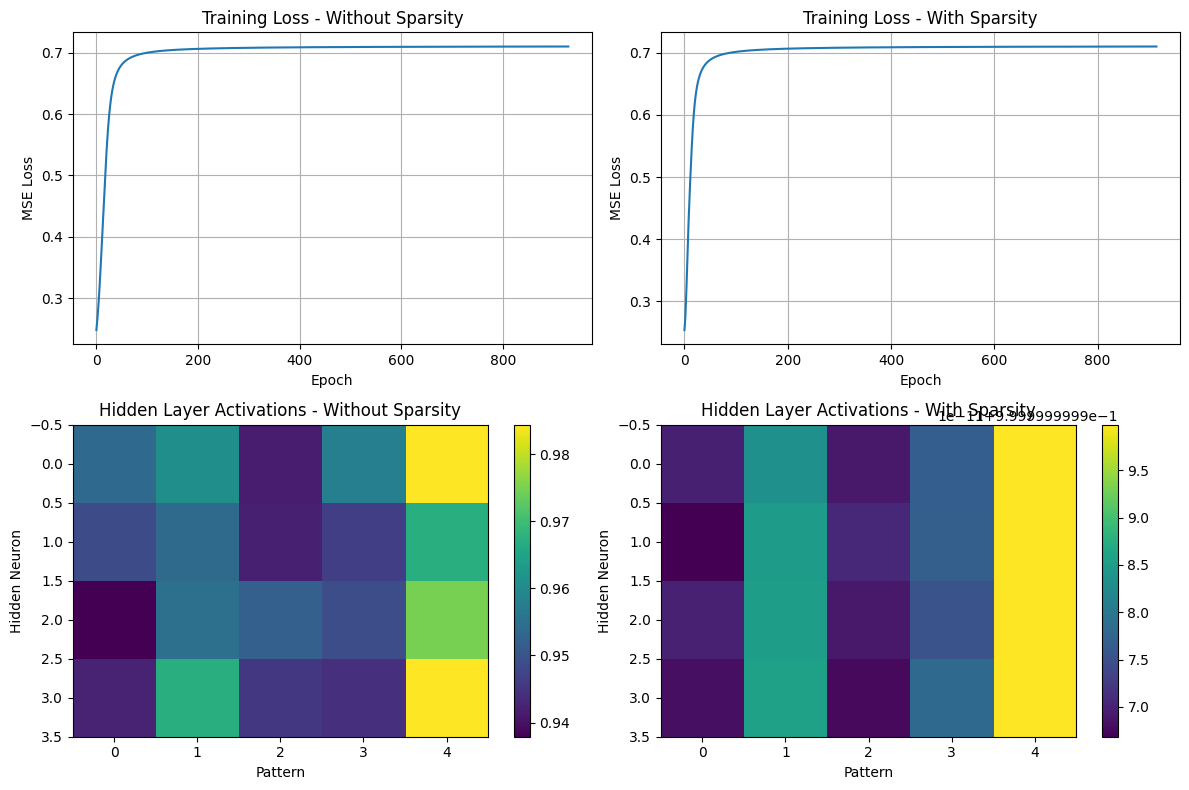

In [ ]:
# Plot results
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(losses_normal)
plt.title("Training Loss - Without Sparsity")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(losses_sparse)
plt.title("Training Loss - With Sparsity")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)

plt.subplot(2,2,3)
plt.imshow(hidden_activations_normal.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Hidden Layer Activations - Without Sparsity")
plt.xlabel("Pattern")
plt.ylabel("Hidden Neuron")

plt.subplot(2,2,4)
plt.imshow(hidden_activations_sparse.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Hidden Layer Activations - With Sparsity")
plt.xlabel("Pattern")
plt.ylabel("Hidden Neuron")

plt.tight_layout()
plt.show()

In [ ]:
# Print comparison
print("\n" + "=" * 60)
print("=== COMPARISON SUMMARY ===")
print("\nAverage Hidden Activation Statistics:")
print("Without Sparsity:")
print(f"Mean Activation: {np.mean(hidden_activations_normal):.6f}")
print(f"Standard Deviation: {np.std(hidden_activations_normal):.6f}")
print(f"% activations < 0.1: {(hidden_activations_normal < 0.1).mean():.6%}")

print("\nWith Sparsity:")
print(f"Mean Activation: {np.mean(hidden_activations_sparse):.6f}")
print(f"Standard Deviation: {np.std(hidden_activations_sparse):.6f}")
print(f"% activations < 0.1: {(hidden_activations_sparse < 0.1).mean():.6%}")
print(f"Target sparsity (p): {ae_sparse.rho:.6f}")

print("\nReconstruction Quality:")
print(f"Without Sparsity - Average MSE: {np.mean([np.mean((patterns_flat[i] - reconstructions_normal[i]) ** 2) for i in range(5)]):.6f}")
print(f"With Sparsity - Average MSE: {np.mean([np.mean((patterns_flat[i] - reconstructions_sparse[i]) ** 2) for i in range(5)]):.6f}")



=== COMPARISON SUMMARY ===

Average Hidden Activation Statistics:
Without Sparsity:
Mean Activation: 0.954880
Standard Deviation: 0.013001
% activations < 0.1: 0.000000%

With Sparsity:
Mean Activation: 1.000000
Standard Deviation: 0.000000
% activations < 0.1: 0.000000%
Target sparsity (p): 0.100000

Reconstruction Quality:
Without Sparsity - Average MSE: 0.710216
With Sparsity - Average MSE: 0.710217


# Qn 2

Generating 100 random 10x10 images...
Generated 100 images of size 10x10
Data range: [0.000, 1.000]
Data mean: 0.494

CREATING AUTOENCODERS

1. UNDERCOMPLETE AUTOENCODER (49 hidden neurons)
Architecture: 100 → 49 → 100
Compression ratio: 0.49

2. OVERCOMPLETE AUTOENCODER (144 hidden neurons)
Architecture: 100 → 144 → 100
Expansion ratio: 1.44

3. SPARSE AUTOENCODER (144 hidden neurons)
Architecture: 100 → 144 → 100
Sparsity parameters: ρ=0.05, β=0.5

TRAINING AUTOENCODERS

Training Undercomplete Autoencoder...
Epoch 0, Loss: 0.085513, MSE: 0.085513
Converged at epoch 184

Training Overcomplete Autoencoder...
Epoch 0, Loss: 0.089061, MSE: 0.089061
Converged at epoch 109

Training Sparse Autoencoder...
Epoch 0, Loss: 8.608062, MSE: 0.086664
Epoch 200, Loss: 0.082747, MSE: 0.050320
Epoch 400, Loss: 0.069943, MSE: 0.030210
Epoch 600, Loss: 0.057894, MSE: 0.022422
Epoch 800, Loss: 0.051587, MSE: 0.018481

FEATURE ANALYSIS

=== Undercomplete AE Feature Analysis ===
Average hidden activation:

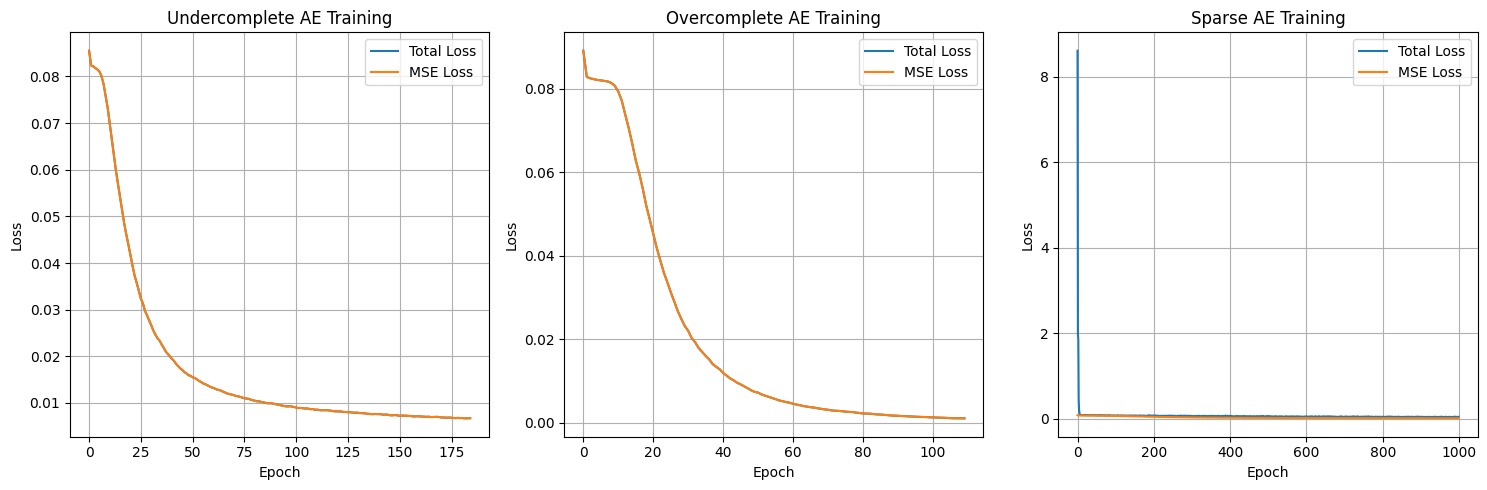


PERFORMANCE COMPARISON

Final Reconstruction MSE:
Undercomplete AE: 0.006729
Overcomplete AE:  0.001048
Sparse AE:        0.015930

Sparsity Analysis (% activations < 0.1):
Undercomplete AE: 0.2500
Overcomplete AE:  0.4222
Sparse AE:        0.9971
Target sparsity:  0.0500


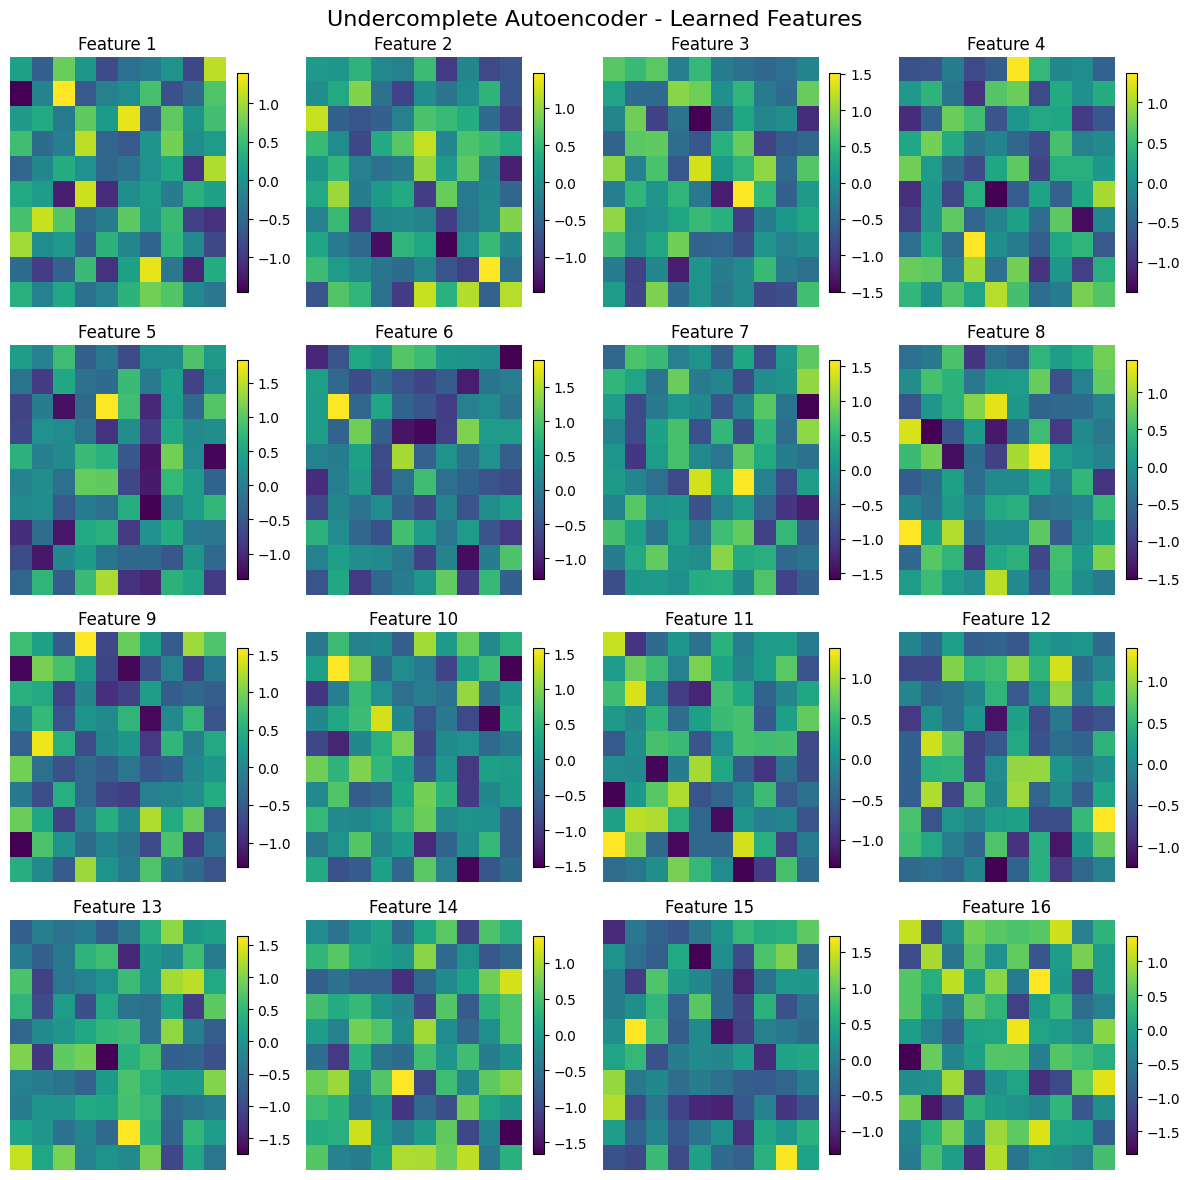

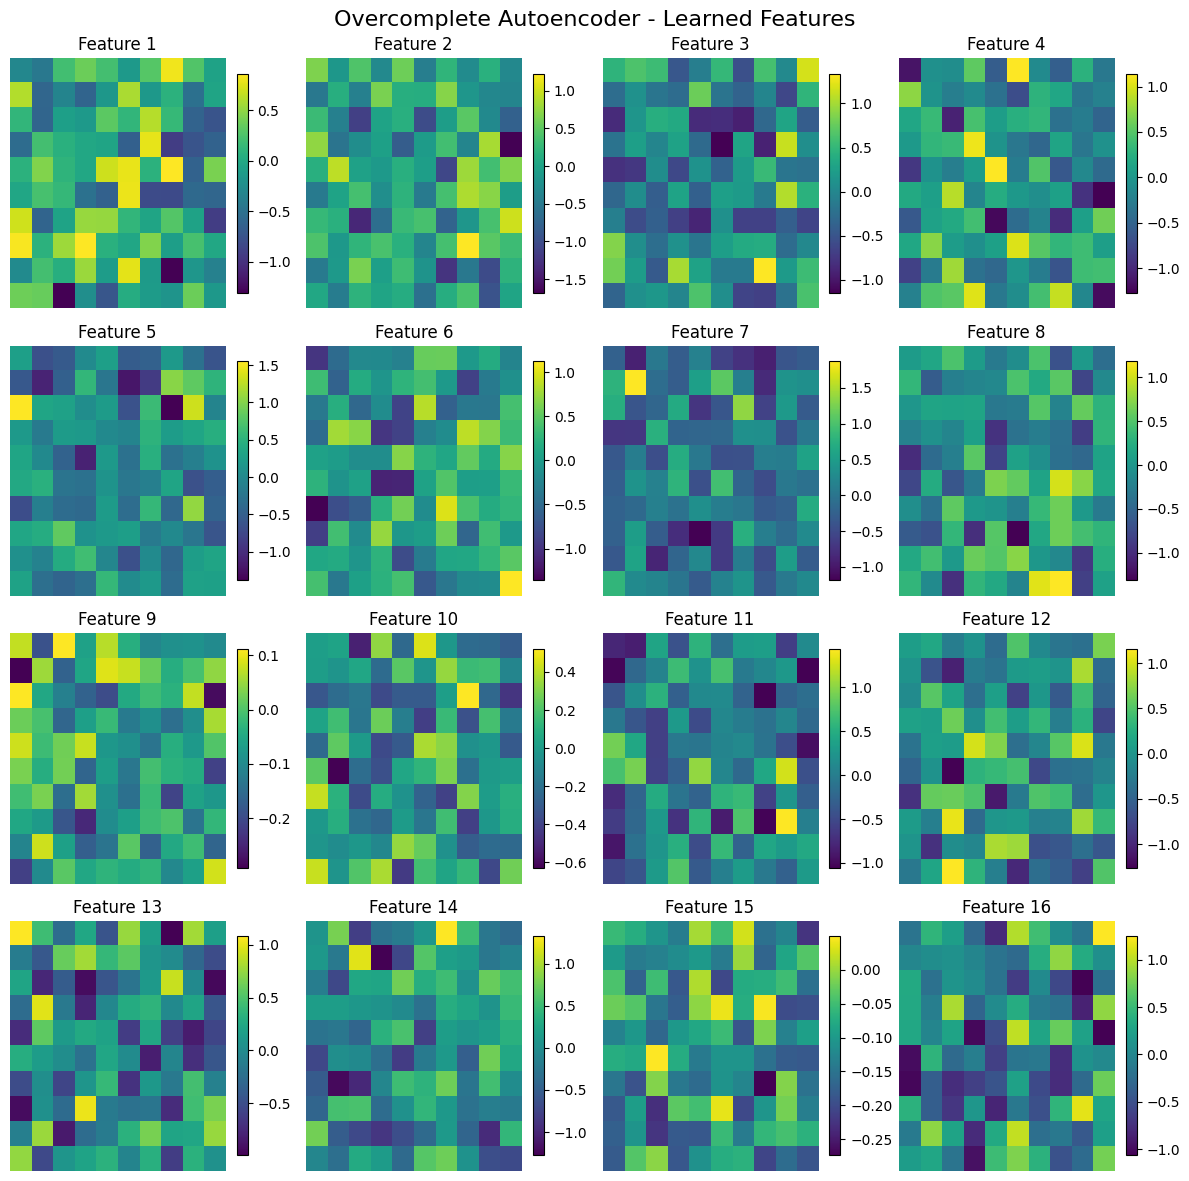

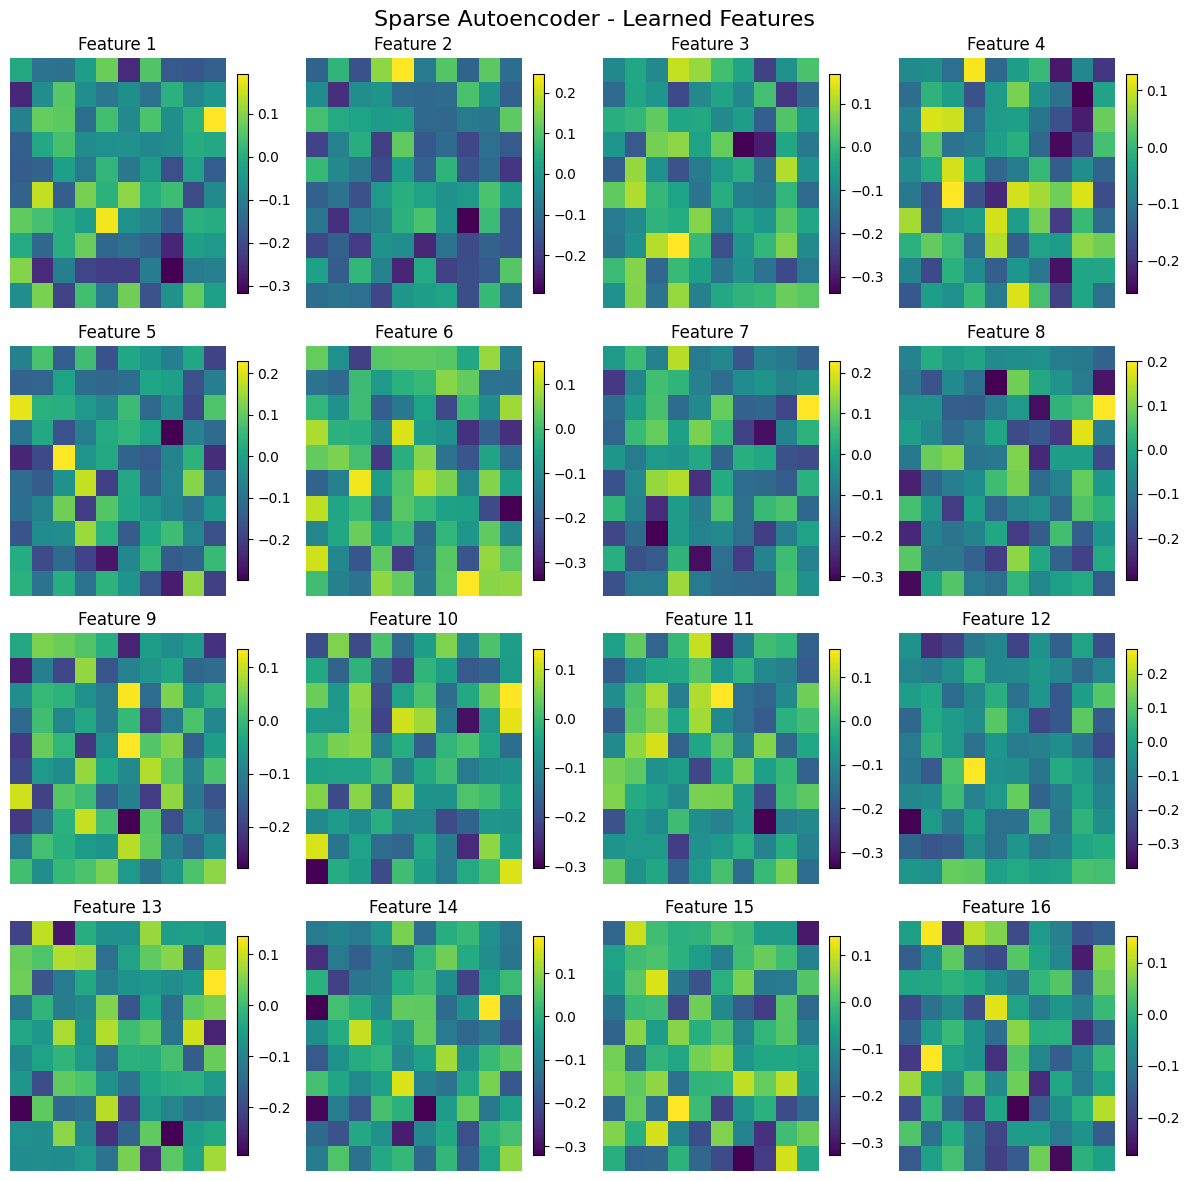

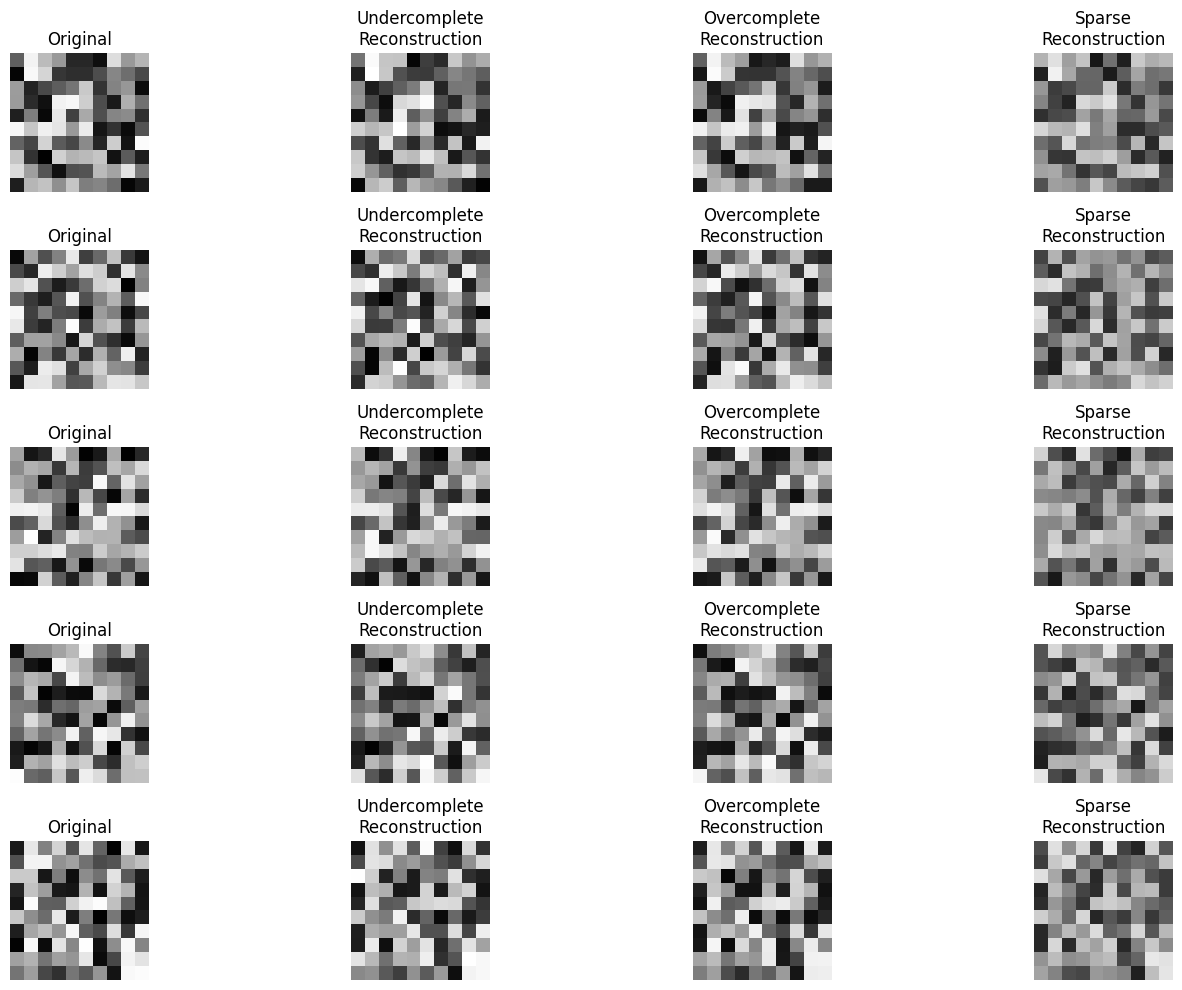

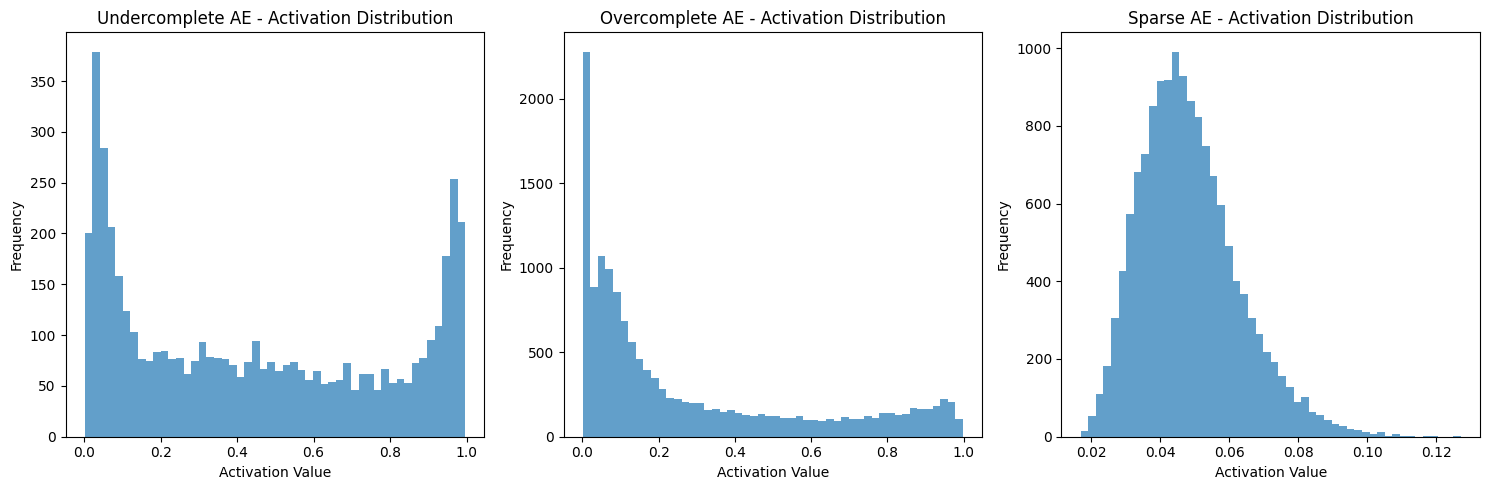


SUMMARY OF FINDINGS

1. UNDERCOMPLETE AUTOENCODER (49 hidden neurons):
   - Learns compressed representation
   - Features tend to be more global and structured
   - Moderate reconstruction quality

2. OVERCOMPLETE AUTOENCODER (144 hidden neurons):
   - Highest capacity for reconstruction
   - May learn noise and overfit
   - Features can be more specialized but potentially redundant

3. SPARSE AUTOENCODER (144 hidden neurons with sparsity):
   - Forces efficient, distributed representation
   - Only a small percentage of neurons active per pattern
   - Learns more meaningful, non-redundant features
   - Sacrifices some reconstruction quality for sparsity



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity=False, rho=0.05, beta=0.5):
        super(Autoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity = sparsity
        self.rho = rho
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def kl_divergence(self, rho_hat):
        """KL divergence for sparsity constraint"""
        rho = torch.tensor(self.rho, device=rho_hat.device)
        return torch.sum(rho * torch.log(rho / (rho_hat + 1e-8)) +
                        (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + 1e-8)))

    def loss_function(self, reconstructed, original, hidden_activations):
        """Custom loss with sparsity penalty"""
        mse_loss = nn.MSELoss()(reconstructed, original)

        if self.sparsity:
            # Calculate average hidden activation for each neuron across batch
            rho_hat = torch.mean(hidden_activations, dim=0)
            sparsity_loss = self.kl_divergence(rho_hat)
            total_loss = mse_loss + self.beta * sparsity_loss
        else:
            total_loss = mse_loss

        return total_loss, mse_loss

def train_autoencoder(model, train_loader, epochs=1000, lr=0.01):
    """Train the autoencoder"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    mse_losses = []

    for epoch in range(epochs):
        total_loss = 0
        total_mse = 0

        for batch in train_loader:
            data = batch[0]
            optimizer.zero_grad()

            hidden, reconstructed = model(data)
            loss, mse_loss = model.loss_function(reconstructed, data, hidden)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mse += mse_loss.item()

        avg_loss = total_loss / len(train_loader)
        avg_mse = total_mse / len(train_loader)
        losses.append(avg_loss)
        mse_losses.append(avg_mse)

        if epoch % 200 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}, MSE: {avg_mse:.6f}')

        # Early stopping
        if epoch > 100 and abs(losses[-1] - losses[-2]) < 1e-6:
            print(f'Converged at epoch {epoch}')
            break

    return losses, mse_losses

def analyze_features(model, data_loader, model_name):
    """Analyze learned features"""
    model.eval()

    # Get hidden activations for all data
    all_hidden = []
    all_data = []

    with torch.no_grad():
        for batch in data_loader:
            data = batch[0]
            hidden, reconstructed = model(data)
            all_hidden.append(hidden)
            all_data.append(data)

    hidden_activations = torch.cat(all_hidden, dim=0)
    data_tensor = torch.cat(all_data, dim=0)

    # Calculate statistics
    avg_activation = torch.mean(hidden_activations, dim=0)
    sparsity = torch.mean((hidden_activations < 0.1).float(), dim=0)

    print(f"\n=== {model_name} Feature Analysis ===")
    print(f"Average hidden activation: {torch.mean(avg_activation):.4f}")
    print(f"Overall sparsity (<0.1): {torch.mean((hidden_activations < 0.1).float()):.4f}")
    print(f"Hidden activation range: [{torch.min(hidden_activations):.4f}, {torch.max(hidden_activations):.4f}]")

    return hidden_activations, avg_activation, sparsity

def visualize_features(model, model_name, num_features=16):
    """Visualize learned features as images"""
    model.eval()

    # Get encoder weights (first layer)
    weights = model.encoder[0].weight.data.cpu().numpy()

    # Reshape weights to 10x10 images
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle(f'{model_name} - Learned Features', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < min(num_features, weights.shape[0]):
            feature = weights[i].reshape(10, 10)
            im = ax.imshow(feature, cmap='viridis', aspect='auto')
            ax.set_title(f'Feature {i+1}')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(models, test_data, model_names):
    """Visualize original and reconstructed images"""
    fig, axes = plt.subplots(5, len(models) + 1, figsize=(15, 10))

    # Show original images in first column
    for i in range(5):
        original = test_data[i].reshape(10, 10).cpu().numpy()
        axes[i, 0].imshow(original, cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

    # Show reconstructions for each model
    for model_idx, (model, name) in enumerate(zip(models, model_names)):
        model.eval()
        with torch.no_grad():
            for i in range(5):
                test_sample = test_data[i:i+1]
                _, reconstructed = model(test_sample)
                recon_img = reconstructed[0].reshape(10, 10).cpu().numpy()

                axes[i, model_idx + 1].imshow(recon_img, cmap='gray', vmin=0, vmax=1)
                axes[i, model_idx + 1].set_title(f'{name}\nReconstruction')
                axes[i, model_idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate 100 random 10x10 images
print("Generating 100 random 10x10 images...")
num_images = 100
image_size = 10
total_pixels = image_size * image_size

# Create random images from uniform distribution
images = np.random.uniform(0.0, 1.0, (num_images, total_pixels))
images_tensor = torch.FloatTensor(images)

# Create data loader
dataset = TensorDataset(images_tensor, images_tensor)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

print(f"Generated {num_images} images of size {image_size}x{image_size}")
print(f"Data range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Data mean: {images.mean():.3f}")

# Define the three autoencoders
print("\n" + "="*60)
print("CREATING AUTOENCODERS")
print("="*60)

# a. Undercomplete autoencoder (49 hidden neurons)
print("\n1. UNDERCOMPLETE AUTOENCODER (49 hidden neurons)")
undercomplete_ae = Autoencoder(input_size=total_pixels, hidden_size=49, sparsity=False)
print(f"Architecture: 100 → 49 → 100")
print(f"Compression ratio: {49/100:.2f}")

# b. Overcomplete autoencoder (144 hidden neurons)
print("\n2. OVERCOMPLETE AUTOENCODER (144 hidden neurons)")
overcomplete_ae = Autoencoder(input_size=total_pixels, hidden_size=144, sparsity=False)
print(f"Architecture: 100 → 144 → 100")
print(f"Expansion ratio: {144/100:.2f}")

# c. Sparse autoencoder (144 hidden neurons with sparsity)
print("\n3. SPARSE AUTOENCODER (144 hidden neurons)")
sparse_ae = Autoencoder(input_size=total_pixels, hidden_size=144, sparsity=True, rho=0.05, beta=0.5)
print(f"Architecture: 100 → 144 → 100")
print(f"Sparsity parameters: ρ={sparse_ae.rho}, β={sparse_ae.beta}")

# Train all models
print("\n" + "="*60)
print("TRAINING AUTOENCODERS")
print("="*60)

print("\nTraining Undercomplete Autoencoder...")
under_losses, under_mse = train_autoencoder(undercomplete_ae, data_loader, epochs=1000, lr=0.01)

print("\nTraining Overcomplete Autoencoder...")
over_losses, over_mse = train_autoencoder(overcomplete_ae, data_loader, epochs=1000, lr=0.01)

print("\nTraining Sparse Autoencoder...")
sparse_losses, sparse_mse = train_autoencoder(sparse_ae, data_loader, epochs=1000, lr=0.01)

# Analyze features
print("\n" + "="*60)
print("FEATURE ANALYSIS")
print("="*60)

under_hidden, under_avg_act, under_sparsity = analyze_features(undercomplete_ae, data_loader, "Undercomplete AE")
over_hidden, over_avg_act, over_sparsity = analyze_features(overcomplete_ae, data_loader, "Overcomplete AE")
sparse_hidden, sparse_avg_act, sparse_sparsity = analyze_features(sparse_ae, data_loader, "Sparse AE")

# Visualizations
print("\n" + "="*60)
print("VISUALIZATIONS")
print("="*60)

# Plot training losses
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(under_losses, label='Total Loss')
plt.plot(under_mse, label='MSE Loss')
plt.title('Undercomplete AE Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(over_losses, label='Total Loss')
plt.plot(over_mse, label='MSE Loss')
plt.title('Overcomplete AE Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(sparse_losses, label='Total Loss')
plt.plot(sparse_mse, label='MSE Loss')
plt.title('Sparse AE Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare final performance
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

print(f"\nFinal Reconstruction MSE:")
print(f"Undercomplete AE: {under_mse[-1]:.6f}")
print(f"Overcomplete AE:  {over_mse[-1]:.6f}")
print(f"Sparse AE:        {sparse_mse[-1]:.6f}")

print(f"\nSparsity Analysis (% activations < 0.1):")
print(f"Undercomplete AE: {torch.mean((under_hidden < 0.1).float()):.4f}")
print(f"Overcomplete AE:  {torch.mean((over_hidden < 0.1).float()):.4f}")
print(f"Sparse AE:        {torch.mean((sparse_hidden < 0.1).float()):.4f}")
print(f"Target sparsity:  0.0500")

# Visualize learned features
visualize_features(undercomplete_ae, "Undercomplete Autoencoder")
visualize_features(overcomplete_ae, "Overcomplete Autoencoder")
visualize_features(sparse_ae, "Sparse Autoencoder")

# Visualize reconstructions
models = [undercomplete_ae, overcomplete_ae, sparse_ae]
model_names = ["Undercomplete", "Overcomplete", "Sparse"]
visualize_reconstructions(models, images_tensor[:5], model_names)

# Additional analysis: Activation distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(under_hidden.flatten().cpu().numpy(), bins=50, alpha=0.7)
plt.title('Undercomplete AE - Activation Distribution')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(over_hidden.flatten().cpu().numpy(), bins=50, alpha=0.7)
plt.title('Overcomplete AE - Activation Distribution')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(sparse_hidden.flatten().cpu().numpy(), bins=50, alpha=0.7)
plt.title('Sparse AE - Activation Distribution')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY OF FINDINGS")
print("="*60)

print("""
1. UNDERCOMPLETE AUTOENCODER (49 hidden neurons):
   - Learns compressed representation
   - Features tend to be more global and structured
   - Moderate reconstruction quality

2. OVERCOMPLETE AUTOENCODER (144 hidden neurons):
   - Highest capacity for reconstruction
   - May learn noise and overfit
   - Features can be more specialized but potentially redundant

3. SPARSE AUTOENCODER (144 hidden neurons with sparsity):
   - Forces efficient, distributed representation
   - Only a small percentage of neurons active per pattern
   - Learns more meaningful, non-redundant features
   - Sacrifices some reconstruction quality for sparsity
""")

# Qn 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import requests
import gzip
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[625], sparsity=False, rho=0.02, beta=0.4):
        super(DenoisingAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.sparsity = sparsity
        self.rho = rho
        self.beta = beta

        # Encoder layers
        encoder_layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            encoder_layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.Sigmoid()
            ])
            prev_size = hidden_size

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers (reverse of encoder)
        decoder_layers = []
        hidden_sizes_rev = hidden_sizes[::-1]
        prev_size = hidden_sizes_rev[0]
        for i, hidden_size in enumerate(hidden_sizes_rev[1:]):
            decoder_layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.Sigmoid()
            ])
            prev_size = hidden_size
        decoder_layers.append(nn.Linear(prev_size, input_size))
        decoder_layers.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers)

    def add_multiplicative_noise(self, x, corruption_level=0.1):
        """Add multiplicative noise to input"""
        noise_mask = torch.bernoulli(torch.ones_like(x) * (1 - corruption_level))
        return x * noise_mask

    def forward(self, x, corruption_level=0.1):
        # Add noise to input
        noisy_x = self.add_multiplicative_noise(x, corruption_level)

        # Encode
        encoded = self.encoder(noisy_x)

        # Decode
        decoded = self.decoder(encoded)

        return encoded, decoded

    def kl_divergence(self, rho_hat):
        """KL divergence for sparsity constraint"""
        rho = torch.tensor(self.rho, device=rho_hat.device)
        return torch.sum(rho * torch.log(rho / (rho_hat + 1e-8)) +
                        (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + 1e-8)))

    def loss_function(self, reconstructed, original, hidden_activations):
        """Binary cross-entropy loss with sparsity penalty"""
        bce_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')

        if self.sparsity:
            # Calculate average hidden activation for each neuron across batch
            rho_hat = torch.mean(hidden_activations, dim=0)
            sparsity_loss = self.kl_divergence(rho_hat)
            total_loss = bce_loss + self.beta * sparsity_loss
        else:
            total_loss = bce_loss

        return total_loss, bce_loss

class DenoisingAutoencoderClassifier(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[625, 100], num_classes=10):
        super(DenoisingAutoencoderClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes

        # Encoder layers
        encoder_layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            encoder_layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.Sigmoid()
            ])
            prev_size = hidden_size

        self.encoder = nn.Sequential(*encoder_layers)

        # Classifier layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_sizes[-1], num_classes),
            nn.Softmax(dim=1)
        )

    def add_multiplicative_noise(self, x, corruption_level=0.1):
        """Add multiplicative noise to input"""
        noise_mask = torch.bernoulli(torch.ones_like(x) * (1 - corruption_level))
        return x * noise_mask

    def forward(self, x, corruption_level=0.1):
        # Add noise to input
        noisy_x = self.add_multiplicative_noise(x, corruption_level)

        # Encode
        encoded = self.encoder(noisy_x)

        # Classify
        classified = self.classifier(encoded)

        return encoded, classified

def load_mnist():
    """Load MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    return train_loader, test_loader

def train_denoising_ae(model, train_loader, test_loader, epochs=50, lr=0.1, corruption_level=0.1):
    """Train the denoising autoencoder"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    train_bce_losses = []
    test_bce_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        total_train_bce = 0

        for batch in train_loader:
            data, _ = batch
            data = data.to(device)

            optimizer.zero_grad()
            hidden, reconstructed = model(data, corruption_level)
            loss, bce_loss = model.loss_function(reconstructed, data, hidden)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_bce += bce_loss.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_train_bce = total_train_bce / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_bce_losses.append(avg_train_bce)

        # Testing
        model.eval()
        total_test_loss = 0
        total_test_bce = 0

        with torch.no_grad():
            for batch in test_loader:
                data, _ = batch
                data = data.to(device)

                hidden, reconstructed = model(data, corruption_level)
                loss, bce_loss = model.loss_function(reconstructed, data, hidden)

                total_test_loss += loss.item()
                total_test_bce += bce_loss.item()

        avg_test_loss = total_test_loss / len(test_loader.dataset)
        avg_test_bce = total_test_bce / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
        test_bce_losses.append(avg_test_bce)

        if epoch % 5 == 0:
            print(f'Epoch {epoch:3d}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

    return train_losses, test_losses, train_bce_losses, test_bce_losses

def train_classifier(model, train_loader, test_loader, epochs=50, lr=0.1, corruption_level=0.1):
    """Train the classifier"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            _, outputs = model(data, corruption_level)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Testing
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for batch in test_loader:
                data, labels = batch
                data, labels = data.to(device), labels.to(device)

                _, outputs = model(data, corruption_level)
                loss = criterion(outputs, labels)

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        if epoch % 5 == 0:
            print(f'Epoch {epoch:3d}: Train Loss = {avg_train_loss:.4f}, Test Acc = {test_accuracy:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

def visualize_results(model, test_loader, model_name, num_samples=5):
    """Visualize weights, activations, and reconstructions"""
    model.eval()

    # Get a batch of test data
    data_iter = iter(test_loader)
    test_data, test_labels = next(data_iter)
    test_data = test_data.to(device)

    with torch.no_grad():
        # Get hidden activations and reconstructions
        hidden, reconstructed = model(test_data[:num_samples])

        # Visualize original, noisy, and reconstructed images
        fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
        fig.suptitle(f'{model_name} - Denoising Results', fontsize=16)

        # Add noise to test data for visualization
        noisy_data = model.add_multiplicative_noise(test_data[:num_samples])

        for i in range(num_samples):
            # Original
            orig_img = test_data[i].cpu().reshape(28, 28)
            axes[0, i].imshow(orig_img, cmap='gray')
            axes[0, i].set_title(f'Original (Label: {test_labels[i]})')
            axes[0, i].axis('off')

            # Noisy
            noisy_img = noisy_data[i].cpu().reshape(28, 28)
            axes[1, i].imshow(noisy_img, cmap='gray')
            axes[1, i].set_title('Noisy Input')
            axes[1, i].axis('off')

            # Reconstructed
            recon_img = reconstructed[i].cpu().reshape(28, 28)
            axes[2, i].imshow(recon_img, cmap='gray')
            axes[2, i].set_title('Reconstructed')
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Visualize weights of first layer
    if hasattr(model.encoder[0], 'weight'):
        weights = model.encoder[0].weight.data.cpu()
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle(f'{model_name} - First Layer Weights', fontsize=16)

        for i, ax in enumerate(axes.flat):
            if i < min(32, weights.shape[0]):
                weight_img = weights[i].reshape(28, 28)
                im = ax.imshow(weight_img, cmap='viridis')
                ax.set_title(f'Neuron {i+1}')
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    # Visualize hidden activations
    if hidden is not None:
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        fig.suptitle(f'{model_name} - Hidden Activations', fontsize=16)

        # Reshape hidden activations if possible
        hidden_np = hidden.cpu().numpy()
        hidden_size = hidden_np.shape[1]

        # Try to reshape to square if possible
        sqrt_size = int(np.sqrt(hidden_size))
        if sqrt_size * sqrt_size == hidden_size:
            for i in range(num_samples):
                activation_map = hidden_np[i].reshape(sqrt_size, sqrt_size)
                axes[0, i].imshow(activation_map, cmap='hot')
                axes[0, i].set_title(f'Sample {i+1} Activation')
                axes[0, i].axis('off')
        else:
            # Just plot as histogram
            for i in range(num_samples):
                axes[0, i].hist(hidden_np[i], bins=20, alpha=0.7)
                axes[0, i].set_title(f'Sample {i+1} Activation Dist')

        # Plot activation statistics
        avg_activation = np.mean(hidden_np, axis=0)
        axes[1, 0].hist(avg_activation, bins=20, alpha=0.7)
        axes[1, 0].set_title('Average Activation Distribution')
        axes[1, 0].set_xlabel('Activation Value')
        axes[1, 0].set_ylabel('Frequency')

        for i in range(1, num_samples):
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    return hidden

def plot_learning_curves(train_losses, test_losses, train_bce_losses, test_bce_losses, model_name):
    """Plot learning curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Total loss
    ax1.plot(train_losses, label='Train Total Loss')
    ax1.plot(test_losses, label='Test Total Loss')
    ax1.set_title(f'{model_name} - Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # BCE loss
    ax2.plot(train_bce_losses, label='Train BCE Loss')
    ax2.plot(test_bce_losses, label='Test BCE Loss')
    ax2.set_title(f'{model_name} - BCE Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_classifier_curves(train_losses, test_losses, train_accuracies, test_accuracies, model_name):
    """Plot classifier learning curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Test Loss')
    ax1.set_title(f'{model_name} - Classification Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(test_accuracies, label='Test Accuracy')
    ax2.set_title(f'{model_name} - Classification Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Using device: cuda


Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.33MB/s]



PART (a): SINGLE HIDDEN LAYER WITH 625 NEURONS
Training single-layer denoising autoencoder...
Epoch   0: Train Loss = 372.8312, Test Loss = 132.5882
Epoch   5: Train Loss = 107.5516, Test Loss = 105.9539
Epoch  10: Train Loss = 101.7124, Test Loss = 100.8072
Epoch  15: Train Loss = 99.1975, Test Loss = 98.1674
Epoch  20: Train Loss = 97.2268, Test Loss = 97.0866
Epoch  25: Train Loss = 96.0962, Test Loss = 96.1936
Epoch  30: Train Loss = 95.1821, Test Loss = 94.9728
Epoch  35: Train Loss = 94.4851, Test Loss = 93.7253
Epoch  40: Train Loss = 93.9200, Test Loss = 93.8390
Epoch  45: Train Loss = 93.6491, Test Loss = 93.0557


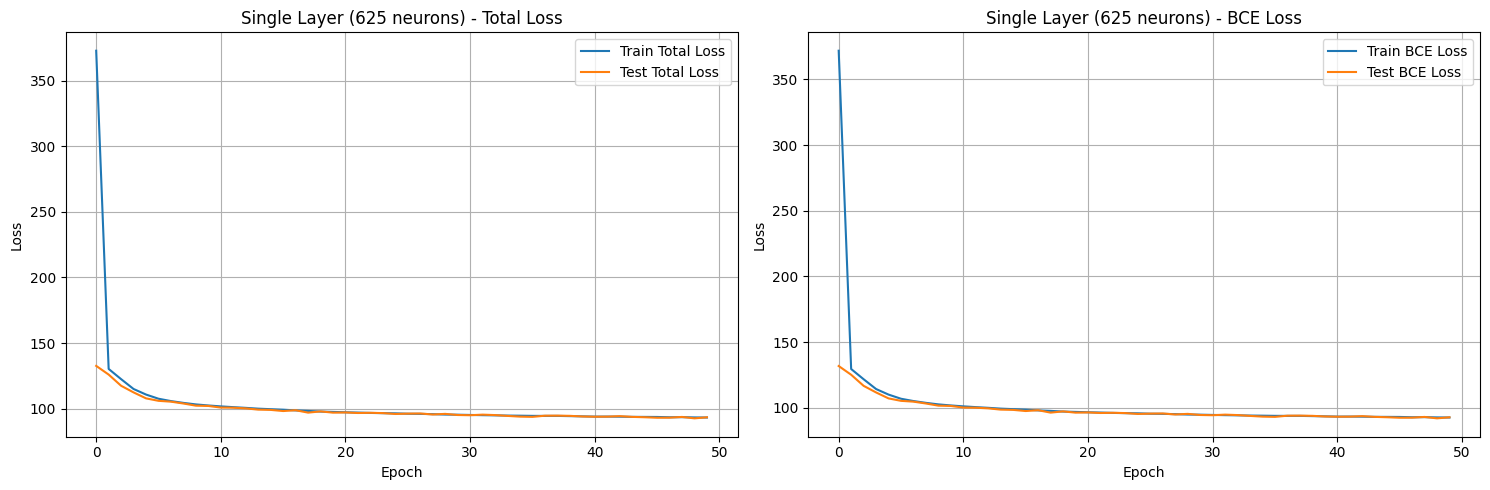

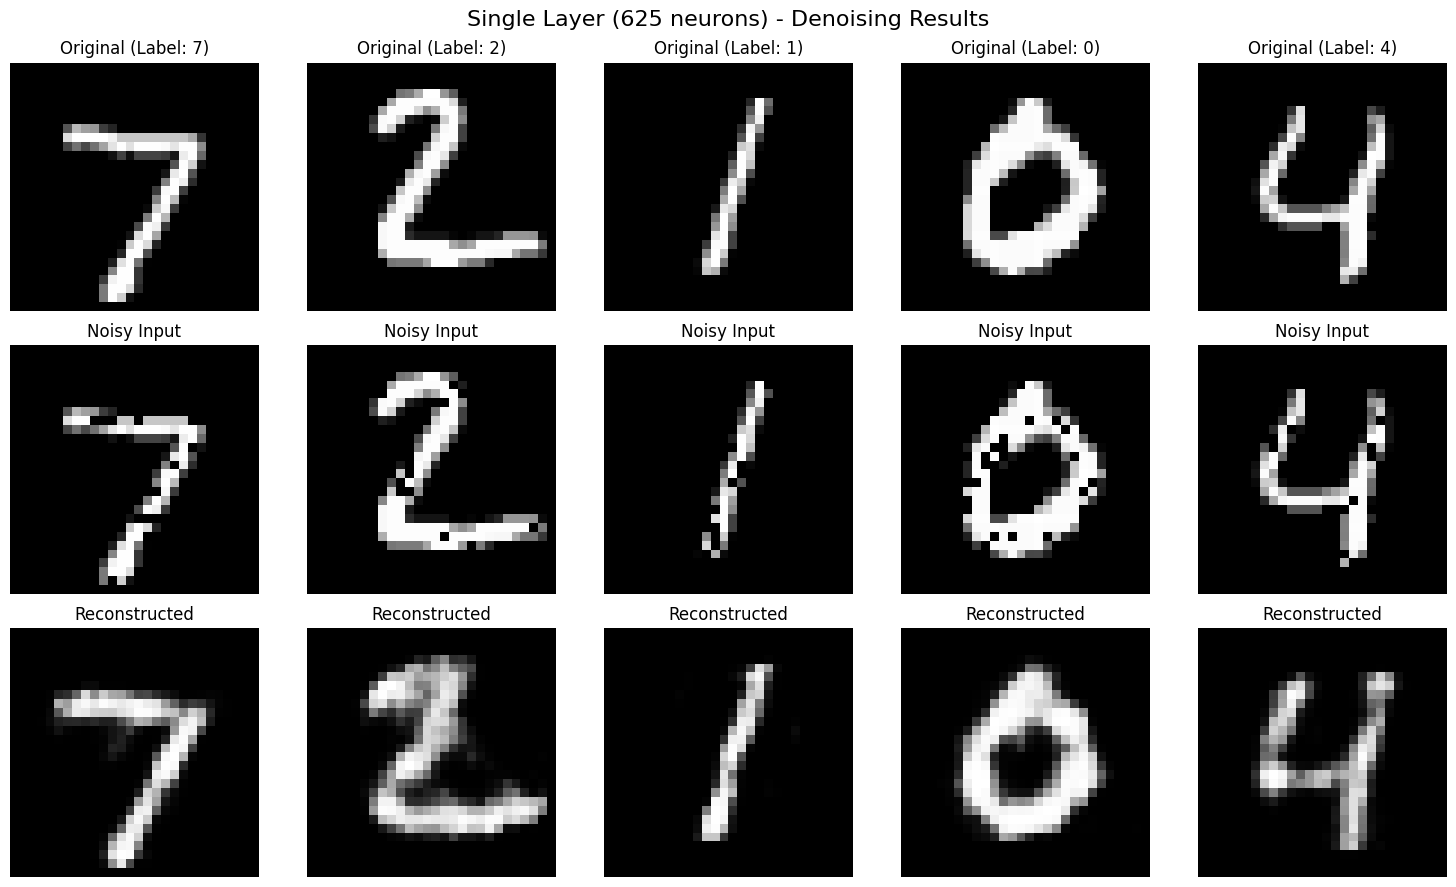

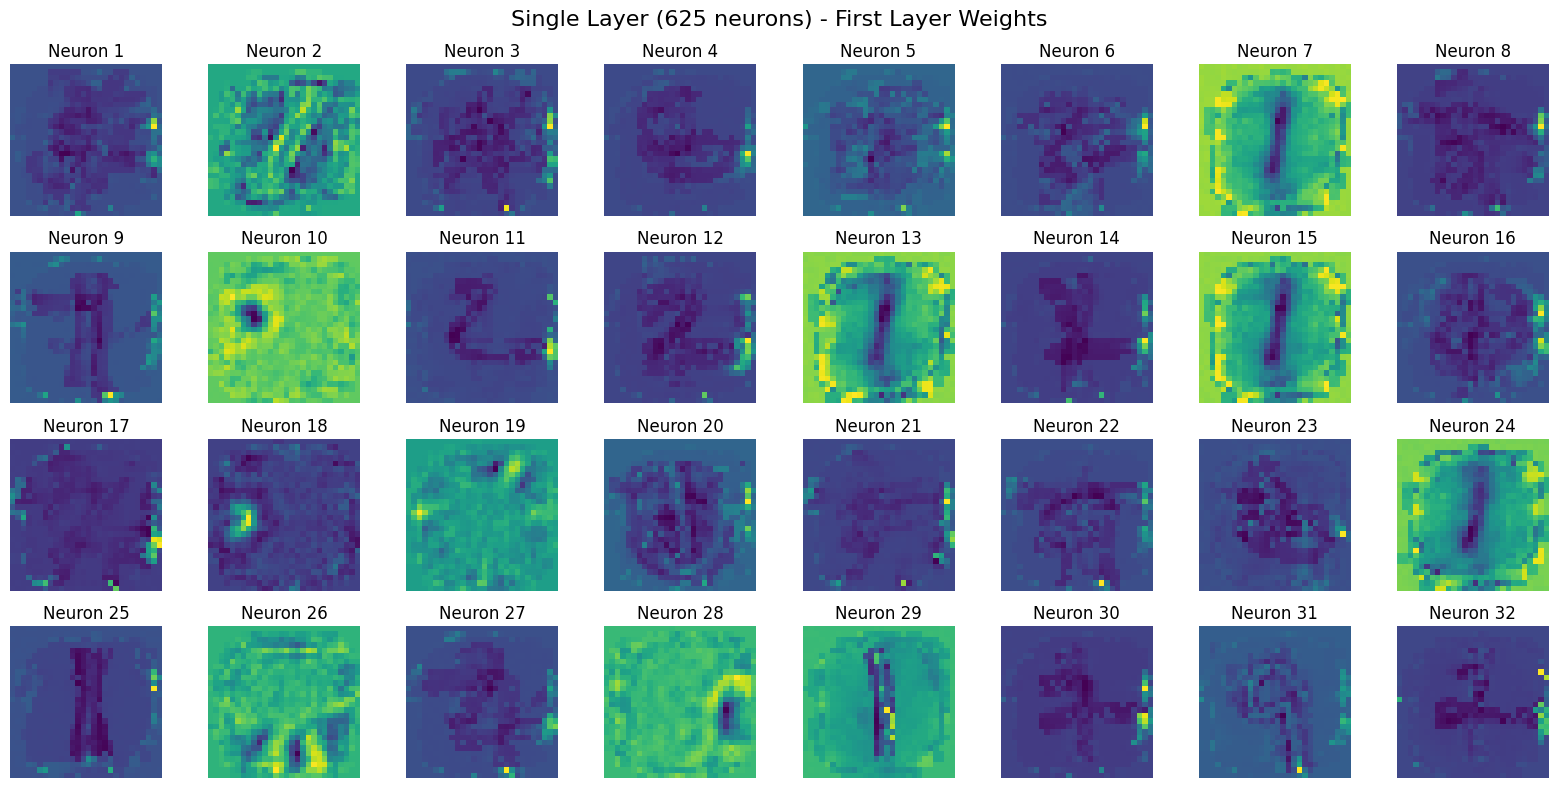

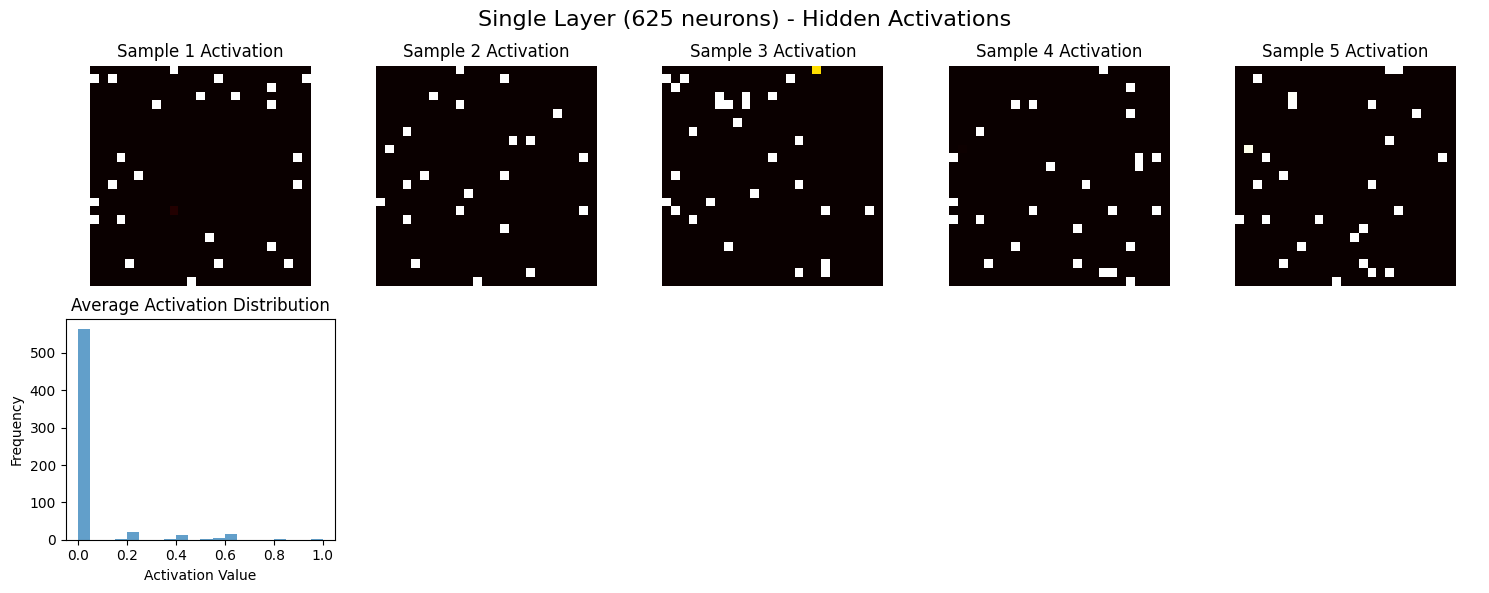


PART (b): TWO HIDDEN LAYERS (625 → 100 NEURONS)
Training two-layer denoising autoencoder...
Epoch   0: Train Loss = 230.5394, Test Loss = 210.7416
Epoch   5: Train Loss = 210.4526, Test Loss = 210.3924
Epoch  10: Train Loss = 210.3732, Test Loss = 210.1558
Epoch  15: Train Loss = 210.4738, Test Loss = 210.1537
Epoch  20: Train Loss = 210.3566, Test Loss = 210.7493
Epoch  25: Train Loss = 210.3974, Test Loss = 210.5998
Epoch  30: Train Loss = 210.4197, Test Loss = 210.0336
Epoch  35: Train Loss = 210.4516, Test Loss = 210.5406
Epoch  40: Train Loss = 210.4475, Test Loss = 210.1219
Epoch  45: Train Loss = 210.4078, Test Loss = 210.3006


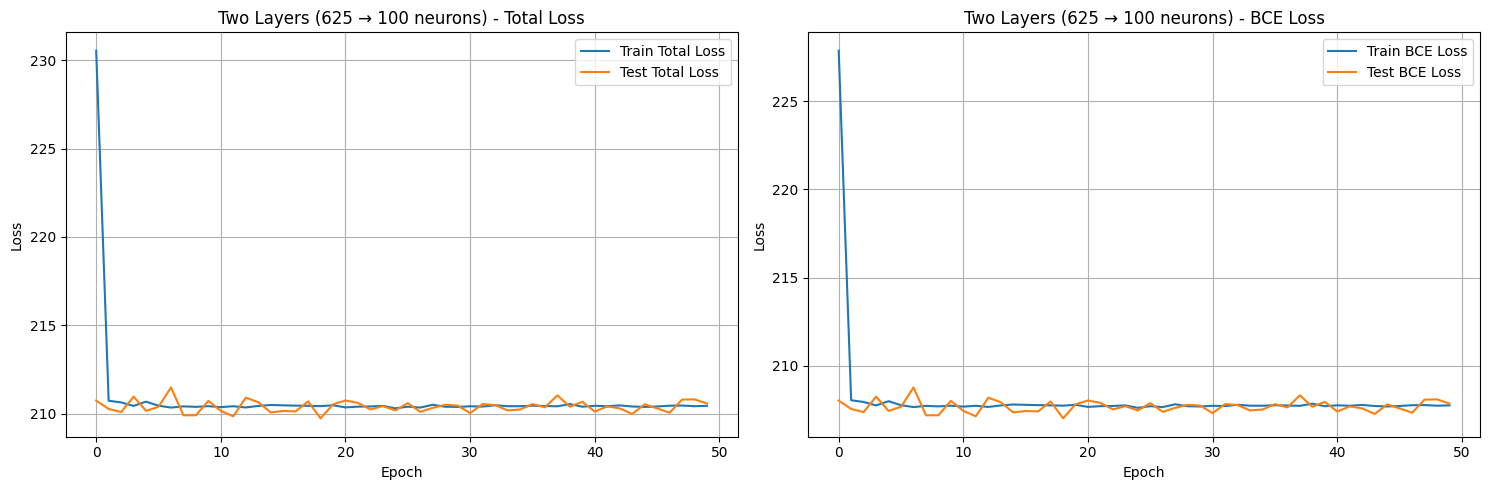

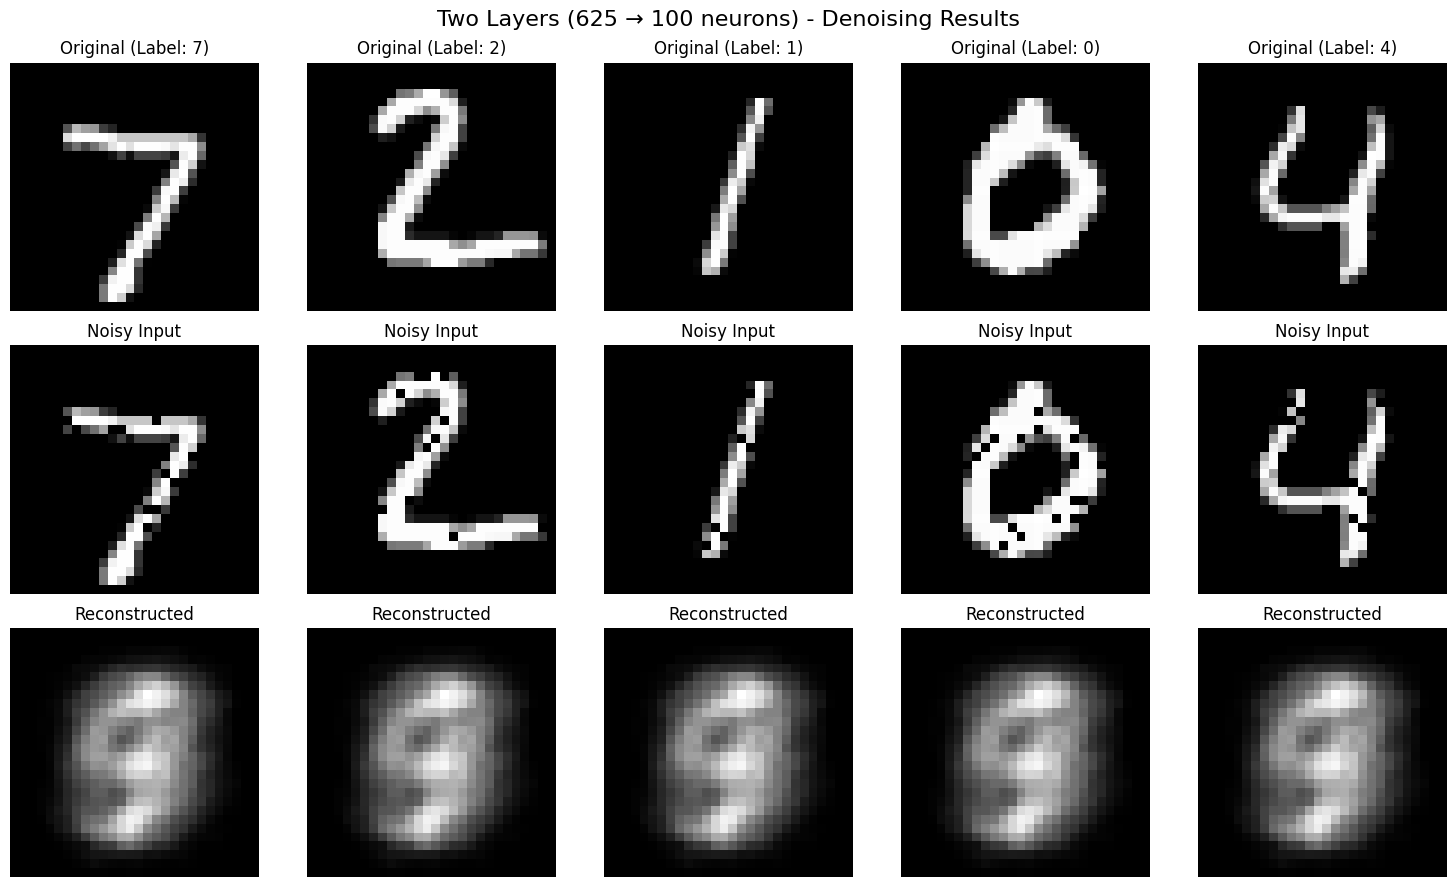

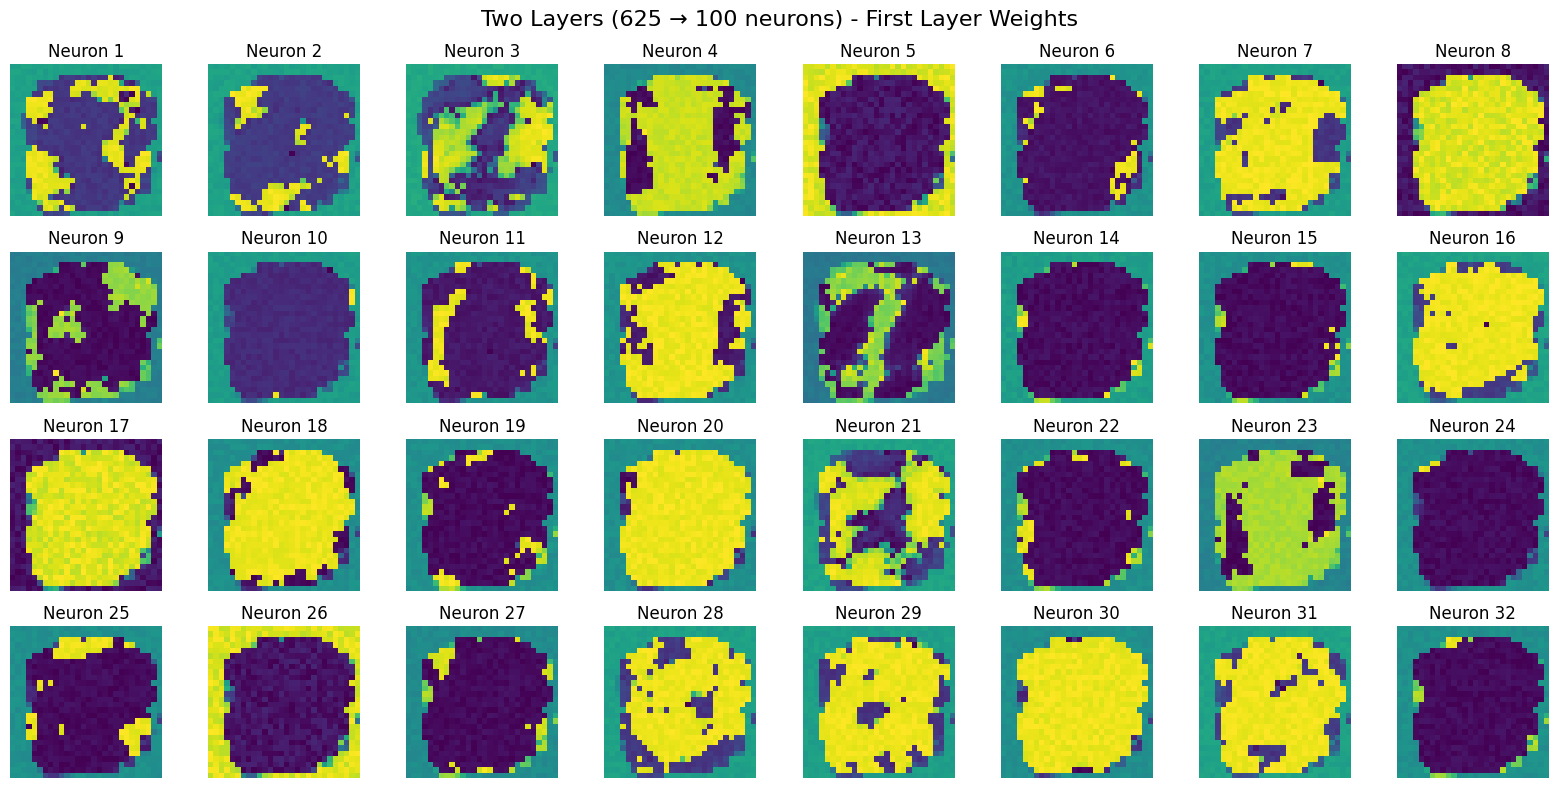

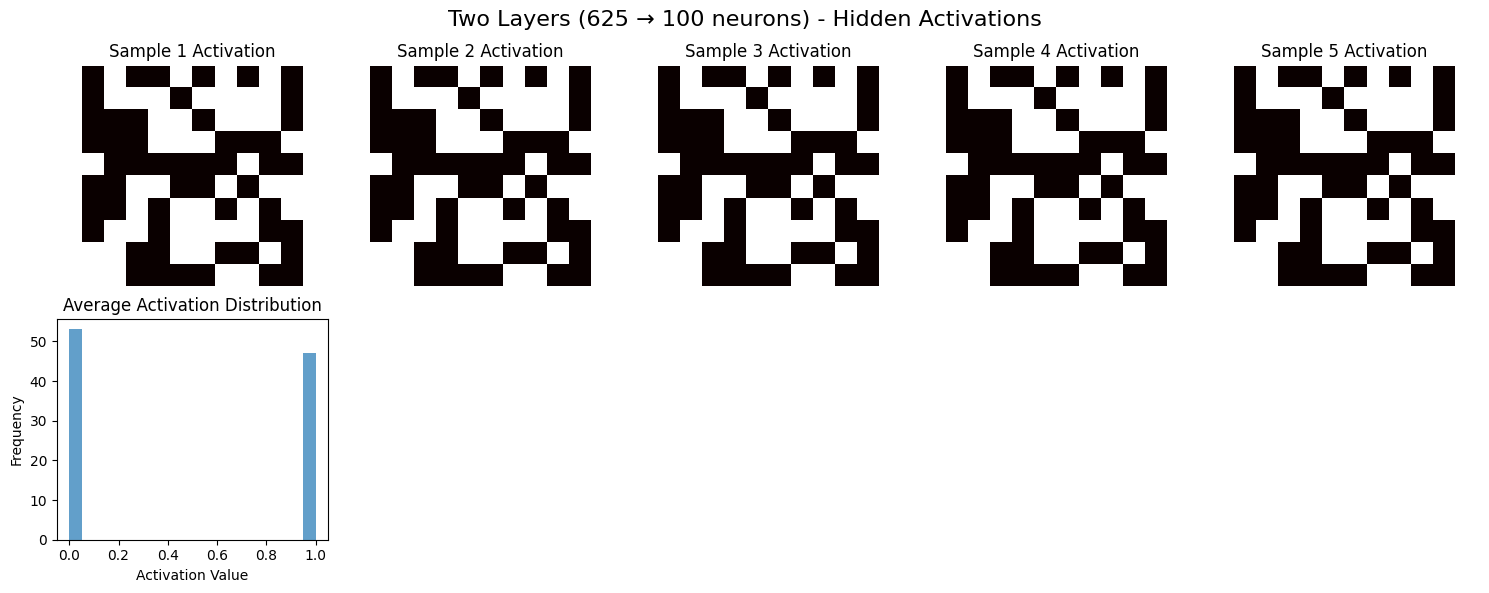


PART (c): CLASSIFIER WITH SOFTMAX LAYER
Training classifier...
Epoch   0: Train Loss = 2.2723, Test Acc = 19.61%
Epoch   5: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  10: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  15: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  20: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  25: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  30: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  35: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  40: Train Loss = 2.3624, Test Acc = 9.80%
Epoch  45: Train Loss = 2.3624, Test Acc = 9.80%


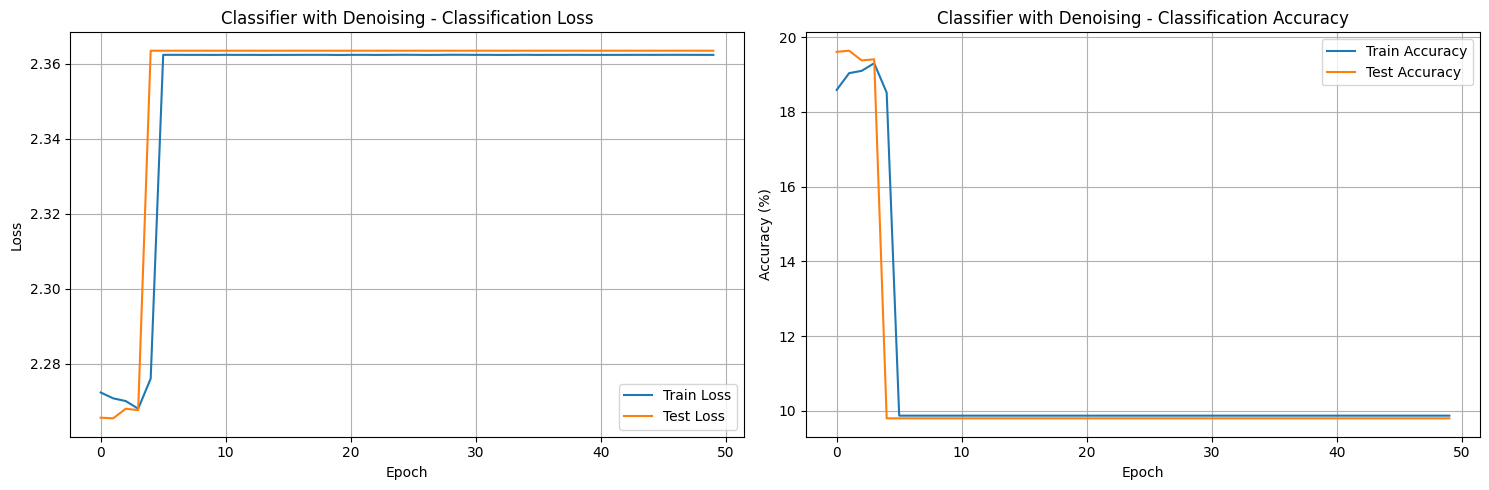


Final Test Accuracy: 9.80%


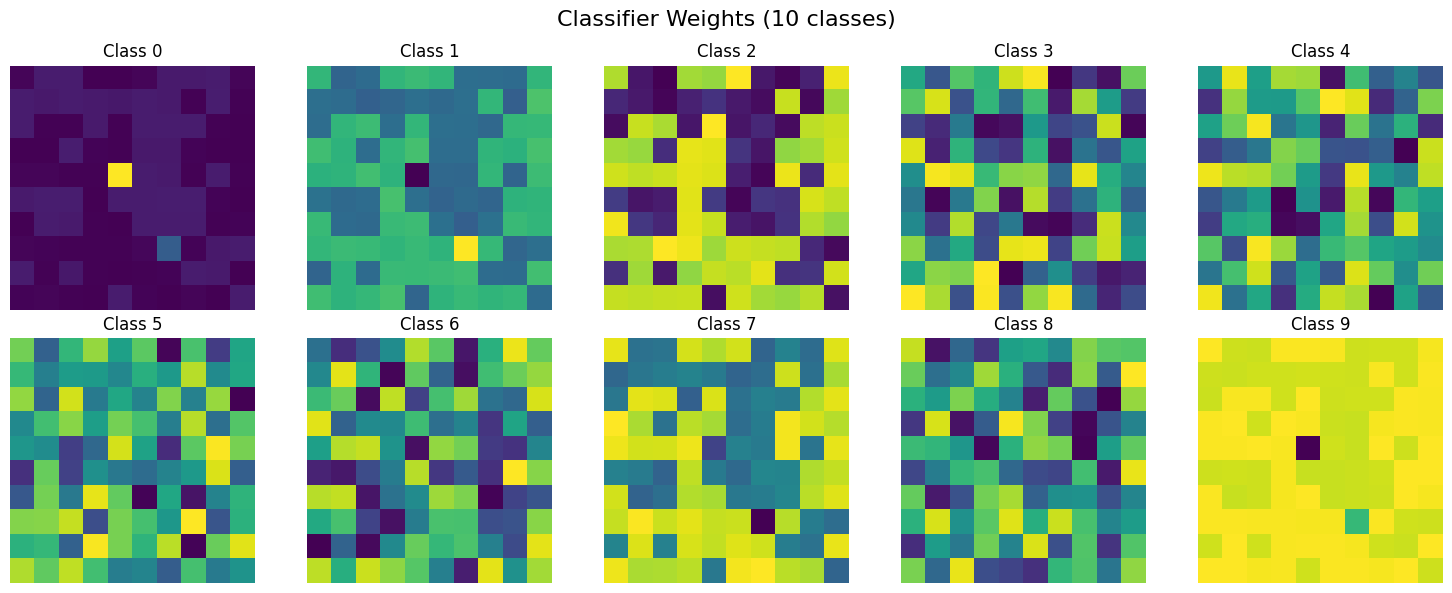


SUMMARY

Single Layer Autoencoder:
  Final Train Loss: 93.2249
  Final Test Loss:  93.3977

Two Layer Autoencoder:
  Final Train Loss: 210.4438
  Final Test Loss:  210.5756

Classifier Performance:
  Final Test Accuracy: 9.80%

Sparsity Analysis (activations < 0.1):
  Single Layer: 0.9597 (target: 0.02)
  Two Layers:   0.5300 (target: 0.02)


In [ ]:
# Load MNIST data
print("Loading MNIST dataset...")
train_loader, test_loader = load_mnist()

print("\n" + "="*70)
print("PART (a): SINGLE HIDDEN LAYER WITH 625 NEURONS")
print("="*70)

# (a) Single hidden layer with 625 neurons
model_a = DenoisingAutoencoder(
    input_size=784,
    hidden_sizes=[625],
    sparsity=True,
    rho=0.02,
    beta=0.4
).to(device)

print("Training single-layer denoising autoencoder...")
train_losses_a, test_losses_a, train_bce_a, test_bce_a = train_denoising_ae(
    model_a, train_loader, test_loader, epochs=50, lr=0.1, corruption_level=0.1
)

# Plot learning curves
plot_learning_curves(train_losses_a, test_losses_a, train_bce_a, test_bce_a,
                    "Single Layer (625 neurons)")

# Visualize results
hidden_a = visualize_results(model_a, test_loader, "Single Layer (625 neurons)")

print("\n" + "="*70)
print("PART (b): TWO HIDDEN LAYERS (625 → 100 NEURONS)")
print("="*70)

# (b) Two hidden layers
model_b = DenoisingAutoencoder(
    input_size=784,
    hidden_sizes=[625, 100],
    sparsity=True,
    rho=0.02,
    beta=0.4
).to(device)

print("Training two-layer denoising autoencoder...")
train_losses_b, test_losses_b, train_bce_b, test_bce_b = train_denoising_ae(
    model_b, train_loader, test_loader, epochs=50, lr=0.1, corruption_level=0.1
)

# Plot learning curves
plot_learning_curves(train_losses_b, test_losses_b, train_bce_b, test_bce_b,
                    "Two Layers (625 → 100 neurons)")

# Visualize results
hidden_b = visualize_results(model_b, test_loader, "Two Layers (625 → 100 neurons)")

print("\n" + "="*70)
print("PART (c): CLASSIFIER WITH SOFTMAX LAYER")
print("="*70)

# (c) Classifier with softmax
model_c = DenoisingAutoencoderClassifier(
    input_size=784,
    hidden_sizes=[625, 100],
    num_classes=10
).to(device)

print("Training classifier...")
train_losses_c, test_losses_c, train_acc_c, test_acc_c = train_classifier(
    model_c, train_loader, test_loader, epochs=50, lr=0.1, corruption_level=0.1
)

# Plot learning curves
plot_classifier_curves(train_losses_c, test_losses_c, train_acc_c, test_acc_c,
                        "Classifier with Denoising")

# Final accuracy
final_accuracy = test_acc_c[-1]
print(f"\nFinal Test Accuracy: {final_accuracy:.2f}%")

# Visualize classifier weights
model_c.eval()
if hasattr(model_c.classifier[0], 'weight'):
    weights = model_c.classifier[0].weight.data.cpu()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Classifier Weights (10 classes)', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < 10:
            # Reshape to visualize (assuming some structure)
            weight_img = weights[i].reshape(10, 10)  # Adjust based on actual dimensions
            im = ax.imshow(weight_img, cmap='viridis')
            ax.set_title(f'Class {i}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"\nSingle Layer Autoencoder:")
print(f"  Final Train Loss: {train_losses_a[-1]:.4f}")
print(f"  Final Test Loss:  {test_losses_a[-1]:.4f}")

print(f"\nTwo Layer Autoencoder:")
print(f"  Final Train Loss: {train_losses_b[-1]:.4f}")
print(f"  Final Test Loss:  {test_losses_b[-1]:.4f}")

print(f"\nClassifier Performance:")
print(f"  Final Test Accuracy: {final_accuracy:.2f}%")

# Compare sparsity
if hidden_a is not None and hidden_b is not None:
    sparsity_a = torch.mean((hidden_a < 0.1).float()).item()
    sparsity_b = torch.mean((hidden_b < 0.1).float()).item()

    print(f"\nSparsity Analysis (activations < 0.1):")
    print(f"  Single Layer: {sparsity_a:.4f} (target: 0.02)")
    print(f"  Two Layers:   {sparsity_b:.4f} (target: 0.02)")